In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import shutil

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from torchinfo import summary

from models.deepLOB.deepLOB_model import Deeplob
from utils.preprocessing_v2 import create_windows, generate_labels, normalize_features, add_features
from utils.training import train_validate # train, validate
from utils.loader import LOBDataset

%load_ext autoreload
%autoreload 2

/home/sc3791/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
destination = 'data/crypto/'
if not os.path.exists(destination) or len(os.listdir(destination)) == 0:
    path = kagglehub.dataset_download("martinsn/high-frequency-crypto-limit-order-book-data")
    shutil.copytree(path, destination)

In [4]:
DATA_PATH = './data/crypto/BTC_1sec.csv'

BATCH_SIZE = 128 # 32
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 'y_100'
LABEL_ALPHA = 3e-4 #1e-5

LEARNING_RATE = 1e-4
# ADAM_B1 = 0.9
# ADAM_B2 = 0.999
# WEIGHT_DECAY= 5e-5 # 1e-5

In [5]:
data_df = pd.read_csv(DATA_PATH, index_col=0)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030728 entries, 0 to 1030727
Columns: 155 entries, system_time to asks_market_notional_14
dtypes: float64(154), object(1)
memory usage: 1.2+ GB


In [6]:
data_df = data_df[:100000]#.copy()
data_df['system_time'] = pd.to_datetime(data_df['system_time'])
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2021-04-12 02:40:21.102749+00:00,59723.315,0.01,260.281395,15.528061,-8.371940e-08,-5.860358e-07,-4.160854e-05,-0.000042,-0.000051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399996,2021-04-12 02:40:22.102749+00:00,59723.315,0.01,0.000000,0.000000,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000042,-0.000051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399997,2021-04-12 02:40:23.102749+00:00,59723.315,0.01,0.000000,0.000000,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000042,-0.000051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399998,2021-04-12 02:40:24.102749+00:00,59723.315,0.01,114.933946,0.000000,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000042,-0.000051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [f"{side}_distance_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
notional_features = [f"{side}_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
cancel_notional_features = [f"{side}_cancel_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
limit_notional_features = [f"{side}_limit_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
market_notional_features = [f"{side}_market_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]

midpoint_delta_features = ['midpoint_delta']

In [8]:
data_df = data_df[meta_features + distance_features + notional_features]
data_df = generate_labels(data_df, HORIZONS, alpha=LABEL_ALPHA)
# data_df = add_features(data_df)
data_df = normalize_features(data_df)
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_notional_5,asks_notional_6,asks_notional_7,asks_notional_8,asks_notional_9,y_10,y_20,y_30,y_50,y_100
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.000387,0.000064,0.000108,0.019618,0.005696,1,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2021-04-12 02:40:21.102749+00:00,59723.315,0.01,260.281395,15.528061,-0.000084,-0.000586,-0.041609,-0.041943,-0.050985,...,0.000166,0.000408,0.000268,0.003611,0.000920,1,1,1,1,1
399996,2021-04-12 02:40:22.102749+00:00,59723.315,0.01,0.000000,0.000000,-0.000084,-0.000251,-0.000586,-0.041943,-0.050985,...,0.000166,0.000408,0.000268,0.003611,0.000920,1,1,1,1,1
399997,2021-04-12 02:40:23.102749+00:00,59723.315,0.01,0.000000,0.000000,-0.000084,-0.000251,-0.000586,-0.041943,-0.050985,...,0.000166,0.000920,0.000408,0.000268,0.003611,1,1,1,1,1
399998,2021-04-12 02:40:24.102749+00:00,59723.315,0.01,114.933946,0.000000,-0.000084,-0.000251,-0.000586,-0.041943,-0.050985,...,0.000166,0.000920,0.000408,0.000268,0.003611,1,1,1,1,1


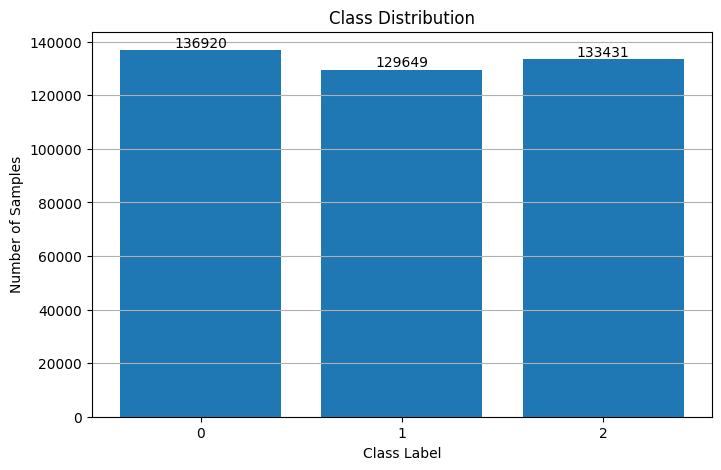

In [9]:
y_val_labels = np.array(data_df[TARGET_HORIZON])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

In [10]:
feature_cols = [col for col in data_df.columns if col not in meta_features and not col.startswith('y_')]

X = data_df[feature_cols].values
y = data_df[TARGET_HORIZON].values

X.shape, y.shape

((400000, 40), (400000,))

In [11]:
X_windows, y_labels = create_windows(X, y, WINDOW_SIZE)
X_windows.shape

(399900, 100, 40)

In [12]:
train_size = int(0.8 * len(X_windows))

X_train, y_train = X_windows[:train_size], y_labels[:train_size]
X_val, y_val = X_windows[train_size:], y_labels[train_size:]

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, 
#     test_size=0.1, 
#     random_state=42, 
#     shuffle=True
# )

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
# print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (319920, 100, 40), (319920,)
Validation shape: (79980, 100, 40), (79980,)


In [17]:
train_dataset = LOBDataset(X_train, y_train, True)
val_dataset = LOBDataset(X_val, y_val, True)
# test_dataset = LOBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(next(iter(train_loader))[0].shape)

torch.Size([128, 1, 100, 40])


In [18]:
model_deepLOB = Deeplob().to(device)
summary(model_deepLOB, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
Deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [ ]:
epochs = 5
learning_rate = 1e-4

normalization="DecPre"
k=4
dataset_type="crypto"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=LEARNING_RATE)

history = train_validate(model_deepLOB, train_loader, val_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

Epoch 1/5, Train Loss: 1.0785, Train Acc: 0.4028, Validation Loss: 1.1154, Validation Acc: 0.3540
Epoch 2/5, Train Loss: 0.9800, Train Acc: 0.5514, Validation Loss: 1.1448, Validation Acc: 0.3631
